#                                       MSc Dissertation Project 

#### Title: Machine Learning Application For Automatic Detection of Faulty Proteins in THz Time-Domain Spectroscopy

## Data Preprocessing of a single spectrum

##### Importing the required libraries

In [238]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
import plotly.graph_objects as go
import plotly.tools as tools
import matplotlib.ticker as ticker
import seaborn as sns
import peakutils
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
print(os.getcwd()) #show current working directory

C:\Users\TAMPU


##### Load THz input data into the pandas dataframe

In [239]:
df_single = pd.read_csv('C:/Users/TAMPU/Downloads/THz_Data/THz_Spectra/5-Acetylsalicylic Acid.csv') #dataframe of single sample
df_single.columns = ['Frequency','Absorbance']

In [240]:
df_single.head()

,Frequency,Absorbance
0,0.97,0.05
1,0.98,0.02
2,1.01,0.02
3,1.04,0.02
4,1.08,0.03


Text(0, 0.5, 'Absorbance')

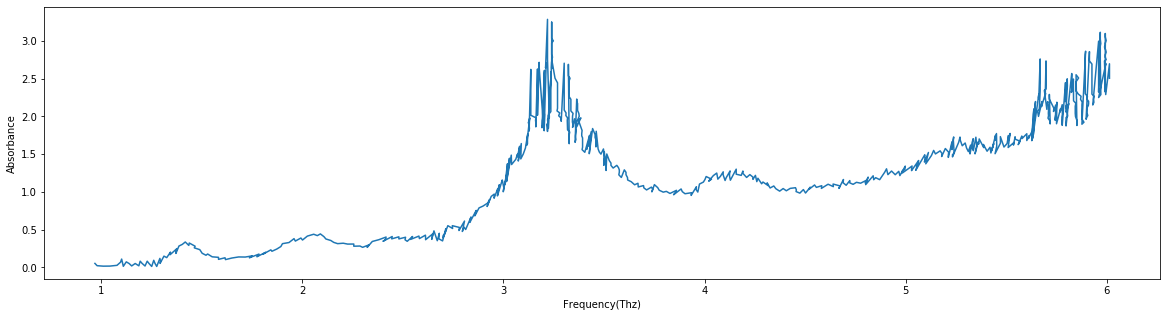

In [241]:
#Plot the THz spectrum of a single sample
plt.figure(figsize=[20,5])
plt.plot(df_single['Frequency'], df_single['Absorbance'])
plt.xlabel('Frequency(Thz)')
plt.ylabel('Absorbance')

##### Baseline Subtraction to remove electronic and chemical noises

In [242]:
# Algorithm reference: Eilers, Paul & Boelens, Hans. (2005). Baseline Correction with Asymmetric Least Squares Smoothing. [Unpublished]. Manuscr
y = df_single['Absorbance']

def baseline_subs(y, l, p, nit=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for n in range(nit):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + l * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [243]:
baseline = baseline_subs(y, l=10**5, p=0.01)

In [244]:
df_single['Absorbance_corrected'] = y - baseline #subtracting baseline line from original spectrum

In [245]:
df_single.head()

,Frequency,Absorbance,Absorbance_corrected
0,0.97,0.05,0.28
1,0.98,0.02,0.25
2,1.01,0.02,0.23
3,1.04,0.02,0.23
4,1.08,0.03,0.24


In [260]:
#plot baseline corrected spectrum from original spectrum
fig = go.Figure()

fig.add_trace(go.Line(x=df_single['Frequency'], y=df_single['Absorbance'],mode='markers',name='raw spectrum plot',marker_color='blue'))

fig.add_trace(go.Line(x=df_single['Frequency'], y=df_single['Absorbance_corrected'],name='baseline corrected plot',marker_color='red'))

# Set options common to all traces with fig.update_traces
fig.update_traces(mode='markers', marker_line_width=1, marker_size=5)
fig.update_layout(title='Raw Spectrum + Baseline_corrected spectrum',yaxis_zeroline=False, xaxis_zeroline=False, xaxis_title="Frequency(THz)", yaxis_title="Absorbance")


fig.show()

Text(0, 0.5, 'Absorbance_corrected')

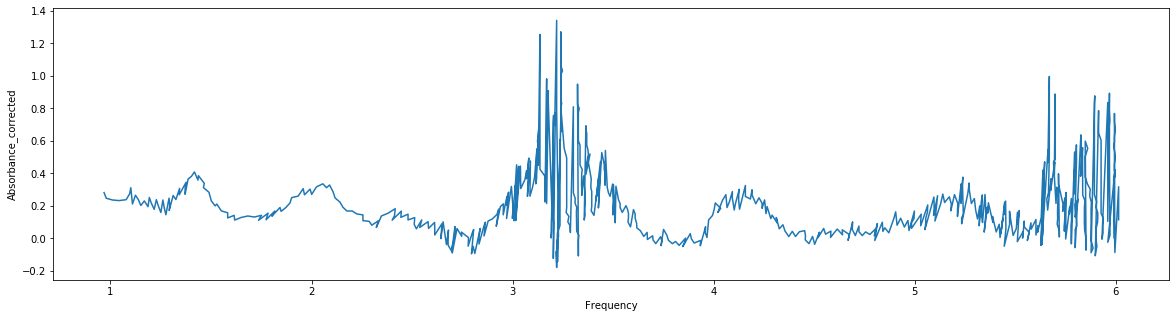

In [247]:
#plot of baseline corrected spectrum 
plt.figure(figsize=[20,5])
plt.plot(df_single['Frequency'], df_single['Absorbance_corrected'])
plt.xlabel('Frequency')
plt.ylabel('Absorbance_corrected')


In [248]:
df_single

,Frequency,Absorbance,Absorbance_corrected
0,0.97,0.05,0.28
1,0.98,0.02,0.25
2,1.01,0.02,0.23
3,1.04,0.02,0.23
4,1.08,0.03,0.24
...,...,...,...
928,6.00,2.29,-0.09
929,6.01,2.70,0.32
930,6.01,2.67,0.28
931,6.01,2.64,0.25


Text(0, 0.5, 'Absorbance_corrected')

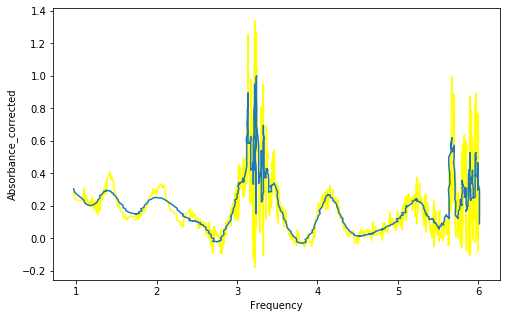

In [256]:
# window size and polynomial order were tuned
x = df_single['Absorbance_corrected']
smooth = savgol_filter(x, 41, 3)
#df_single['Absorbance_corrected'] = smooth
plt.figure(figsize=[8,5])
plt.plot(df_single['Frequency'],df_single['Absorbance_corrected'], color='yellow')
plt.plot(df_single['Frequency'], smooth)
plt.xlabel('Frequency')
plt.ylabel('Absorbance_corrected')

Text(0, 0.5, 'Absorbance_smoothed')

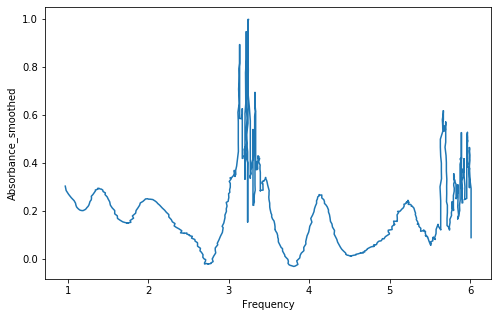

In [251]:
#plot of spectrum after smoothing
smooth = savgol_filter(x, 41, 3)
df_single['smooth'] = smooth

plt.figure(figsize=[8,5])
#plt.plot(df_single['Frequency'],df_single['smooth'], color='yellow')
plt.plot(df_single['Frequency'], df_single['smooth'])
plt.xlabel('Frequency')
plt.ylabel('Absorbance_smoothed')

## Peak detection of single spectrum using peakutils

In [252]:
pip install peakutils

Note: you may need to restart the kernel to use updated packages.


In [253]:
import numpy
import peakutils
from peakutils.plot import plot as pplot
from matplotlib import pyplot
%matplotlib inline

[264 347 700 821 889]


Text(0.5, 1.0, 'First estimate without smoothing')

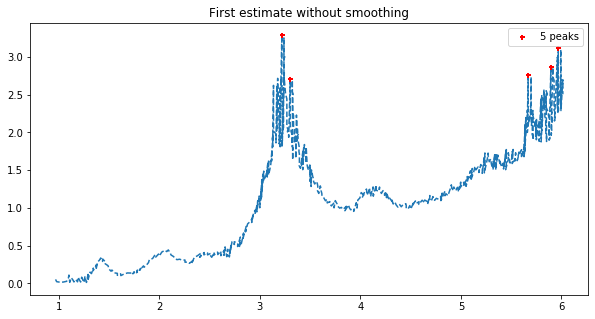

In [255]:
# without smoothing
x = df_single['Frequency']
y = df_single['Absorbance']
peaks = peakutils.indexes(y, thres=0.8, min_dist=51) #threshold setting and minimum distance tuning
print(peaks)
pyplot.figure(figsize=(10,5))
pplot(x, y, peaks)
pyplot.title('First estimate without smoothing')

#### Applying peak detection on smoothed and baseline subtracted spectra yields better results as shown below

[190 320]


Text(0.5, 1.0, 'First estimate with smoothing')

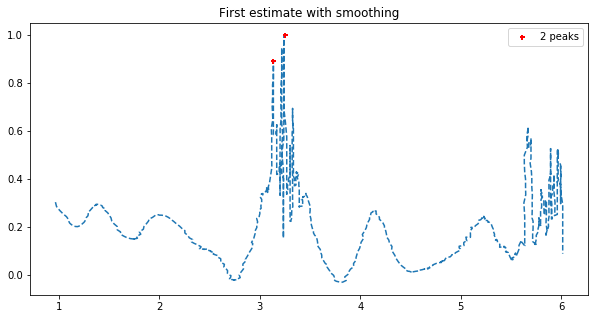

In [19]:
x = df_single['Frequency']
y = df_single['smooth']
indexes1 = peakutils.indexes(y, thres=0.8, min_dist=51) #threshold setting and minimum distance tuning 
print(indexes1)
pyplot.figure(figsize=(10,5))
pplot(x, y, indexes1)
pyplot.title('First estimate with smoothing')

##### The two peaks detected are at 190 frequency bin and 320 frequency

In [20]:
df_single['Absorbance_corrected'] = smooth

In [21]:
df_single

,Frequency,Absorbance,Absorbance_corrected,smooth
0,0.96824,0.05270,0.302928,0.302928
1,0.97903,0.02243,0.284886,0.284886
2,1.00977,0.01630,0.268860,0.268860
3,1.04299,0.01725,0.254765,0.254765
4,1.07799,0.02724,0.242519,0.242519
...,...,...,...,...
928,5.99542,2.29059,0.341166,0.341166
929,6.01411,2.69870,0.292968,0.292968
930,6.01411,2.66804,0.235198,0.235198
931,6.01411,2.64122,0.167237,0.167237


# Data Preprocessing of all the spectra in the dataset

In [22]:
# Returns a list of names in list files. 
from glob import glob
print("Using glob()") 
all_files = glob('/Users/TAMPU/Downloads/THz_data/THz_Spectra/*.csv',  
                   recursive = True) 
for file_name in all_files: 
   
    print(file_name) 

Using glob()
/Users/TAMPU/Downloads/THz_data/THz_Spectra\1,4-Benzoquinone.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\2-Acetylsalicylic Acid.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\2-Deoxy-D-Glucose.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\5-Acetylsalicylic Acid.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\9-Ethyl carbazole.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Acetycholine Chloride.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Acetylcholine Bromide.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Acetylcholine Iodide.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Adenosine-5-Diphosphate.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Adenosine-5-Triphosphate.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Anthracene.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Anthraquinone.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Asparagine.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Aspartic Acid.csv
/Users/TAMPU/Downloads/THz_data/THz_Spectra\Bolid fi

In [23]:
#define function to transform and bin frequency in each csv file and then combine all of them to a single dataframe
def bin_transform(path):
    #read csv file
    df = pd.read_csv(path)
   
    
    df.columns = ['Frequency','Absorbance']
    
    #baseline subtraction 
    y = df['Absorbance']
    
    def baseline_als(y, lam, p, niter=10): # Algorithm reference: Eilers, Paul & Boelens, Hans. (2005). Baseline Correction with Asymmetric Least Squares Smoothing. [Unpub
        L = len(y)
        D = sparse.csc_matrix(np.diff(np.eye(L), 2))
        w = np.ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
    
    baseline = baseline_als(y, lam=10**5, p=0.01)
    df['Absorbance_corrected'] = y - baseline
    
    #smoothing using savgol_filter
    smooth = savgol_filter(df['Absorbance_corrected'], 41, 2)
    df['Absorbance_corrected'] = smooth
    
    
    #bin frequency of each file
    bins = np.linspace(min(df['Frequency']), max(df['Frequency']), num = 500)
    df['Frequency']=np.digitize(df['Frequency'],bins)
    df = df.groupby(df['Frequency'])['Absorbance_corrected'].median()
    df.fillna(0)
    
    #tranform data to a wider form
    df = pd.DataFrame(df)

    df_wide=df.pivot_table(columns = 'Frequency')
    
    
    return df_wide

In [24]:
path =  r'C:/Users/TAMPU/Downloads/THz_Data/THz_Spectra'
all_files = glob(path + "/*.csv")
df = pd.DataFrame()
#data = []
#applying bin_tranform and combine all files after baseline subtraction, smoothing and frequency binning
for filename in all_files:
    
    temp=bin_transform(filename)
    df.fillna(0)
    temp.fillna(0)
    
    df_update = pd.concat((df,temp),ignore_index = True, sort= True)
    
    df = df_update
    


In [25]:
temp

Frequency,1,5,6,7,8,9,11,12,13,14,...,491,492,493,494,495,496,497,498,499,500
Absorbance_corrected,0.024641,0.026533,0.029861,0.028273,0.031297,0.032581,0.033713,0.035522,0.034693,0.036198,...,0.377495,0.519663,0.374501,0.514746,0.539182,0.311581,0.179064,0.179724,0.218964,0.25197


# The dataframe after combining all the files

In [26]:
df = df.fillna(0)
df

Frequency,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.061133,0.061552,0.000000,0.060434,0.000000,0.000000,0.059094,0.000000,0.057407,0.056768
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.194196,0.197335,0.194955,0.263628,0.278836,0.000000,0.225053,0.147548,0.041053,0.068384
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.068047,0.078529,0.089821,0.114832,0.101922,0.000000,0.128552,0.143081,0.158420,0.174568
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.393918,0.256297,0.000000,0.390824,0.486196,0.000000,0.308901,0.321172,0.000000,0.375455
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.136816,0.154413,0.572984,0.967579,0.519609,0.793037,0.287533,0.496496,0.324981,0.298432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.440701,0.806613,0.981674,0.575365,0.244348,0.274532,0.000000,0.376331,0.482402,0.524501
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.077791,0.079363,0.080377,0.081364,0.083262,0.082326,0.084614,0.086331,0.087944,0.089090
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.000000,0.845330,0.000000,0.865341,0.000000,0.000000,0.885430,0.000000,0.000000,0.905596
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,0.004417,0.000000,-0.000069,0.000000,-0.003438,-0.005688,-0.007939,-0.010193,-0.012449,-0.014707


# Visualization of overlap of all spectra

Text(0.5, 0, 'Frequency(binned)')

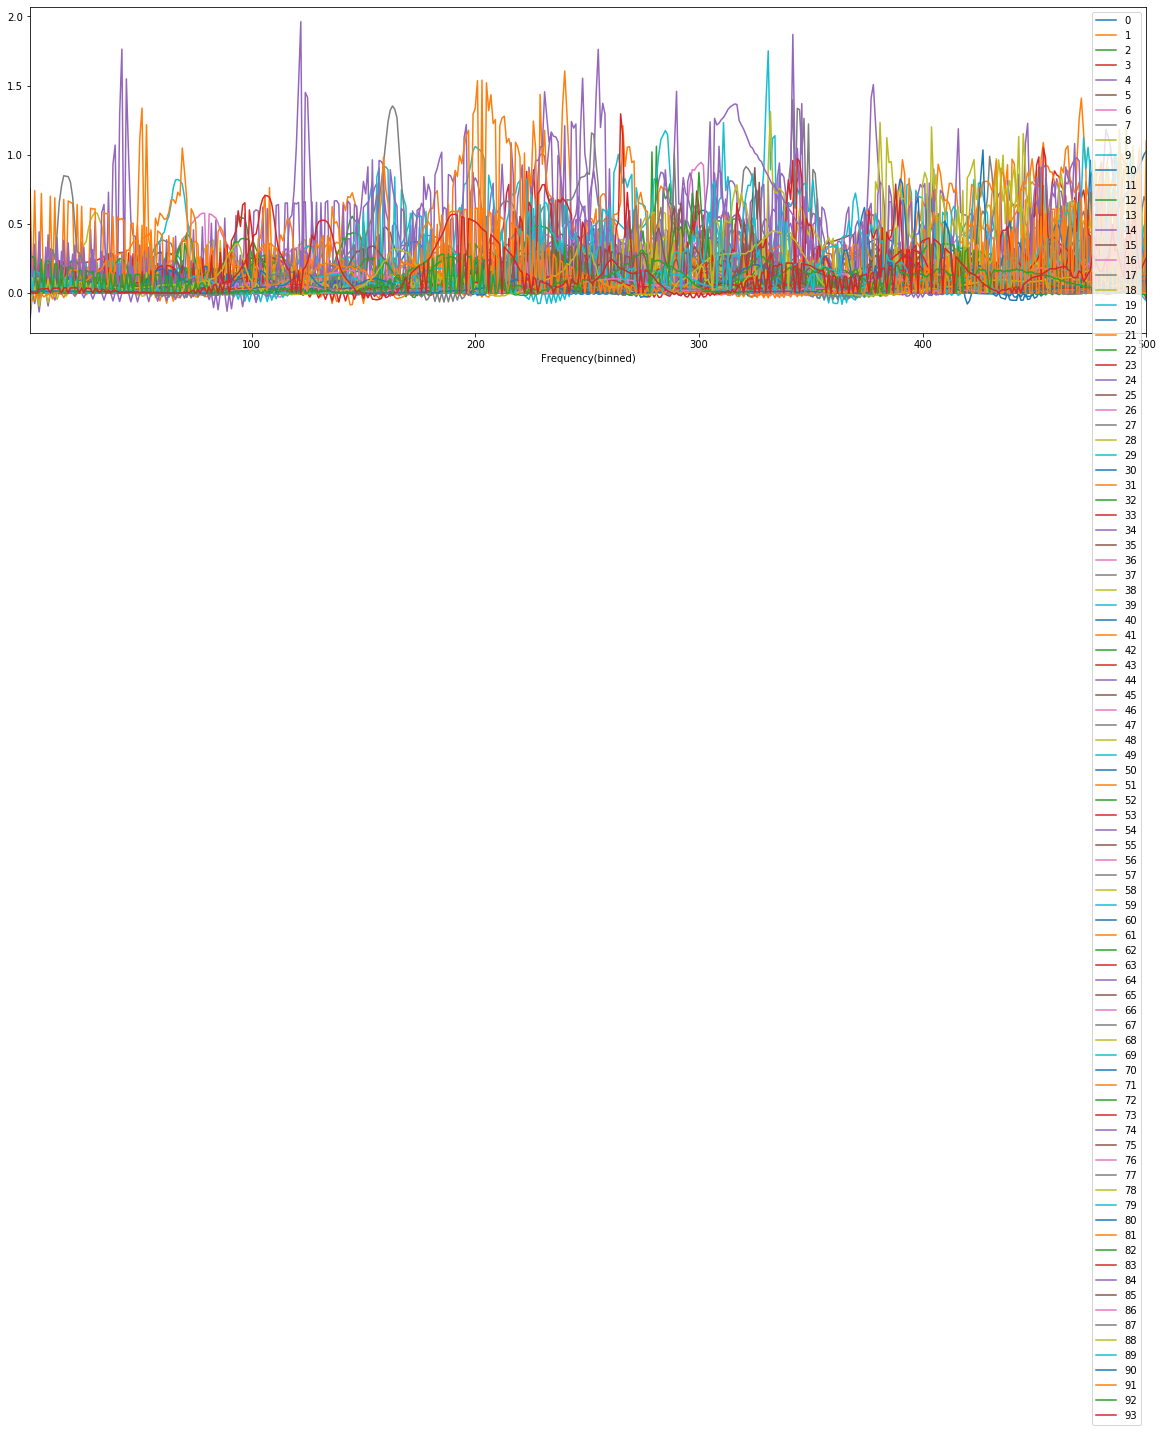

In [27]:
#ploting raw spectra of all samples
df.T.plot(figsize=[20,6])
plt.xlabel('Frequency(binned)')

###### Extracting filename for our reference purpose

In [28]:
import pandas as pd
from glob import glob

files = glob('/Users/TAMPU/Downloads/THz_data/THz_Spectra/*.csv')

df1 = pd.concat([pd.read_csv(fp).assign(New=os.path.basename(fp)) for fp in files])

C:\Users\TAMPU\Downloads\ana3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [29]:
df1.New.unique()

array(['1,4-Benzoquinone.csv', '2-Acetylsalicylic Acid.csv',
       '2-Deoxy-D-Glucose.csv', '5-Acetylsalicylic Acid.csv',
       '9-Ethyl carbazole.csv', 'Acetycholine Chloride.csv',
       'Acetylcholine Bromide.csv', 'Acetylcholine Iodide.csv',
       'Adenosine-5-Diphosphate.csv', 'Adenosine-5-Triphosphate.csv',
       'Anthracene.csv', 'Anthraquinone.csv', 'Asparagine.csv',
       'Aspartic Acid.csv', 'Bolid fish paste.csv',
       'Buckminster Fullerene.csv', 'Carbazole.csv',
       'Copper II Oxide.csv', 'Cyclotriphosphazene.csv',
       'D(+)Turanose.csv', 'D(+)Tyrosine.csv', 'D-Serine.csv',
       'D-Talose.csv', 'DL-Cysteine.csv', 'DL-Lysine.csv', 'Fructose.csv',
       'Glutamine.csv', 'Glycine.csv', 'Glycogen.csv', 'Glyphosate.csv',
       'Guanosine-5-Diphosphate.csv', 'Guanosine-5-Triphoshie.csv',
       'Hydrogen.csv', 'Hydroquinone.csv', 'Isophthalic.csv',
       'Kojibiose.csv', 'Kontomin.csv', 'L(+)Arginine.csv',
       'L(+)Lysine.csv', 'L-Asparagine Monohydrate.csv'

In [30]:
df2=pd.DataFrame()
df2['New'] = df1['New'].to_numpy()

In [31]:
df2['filenames'] = df2.New.drop_duplicates()

In [32]:
df2 = df2['filenames'].dropna()

In [33]:
df2

0              1,4-Benzoquinone.csv
796      2-Acetylsalicylic Acid.csv
2145          2-Deoxy-D-Glucose.csv
2948     5-Acetylsalicylic Acid.csv
3881          9-Ethyl carbazole.csv
                    ...            
92383         Terephthalic Acid.csv
93403                 Tetracene.csv
94426      Thallium _I_ Bromide.csv
95481     Thiamin Hydrochloride.csv
96541                 Trehalose.csv
Name: filenames, Length: 94, dtype: object

In [34]:
df2 = df2.reset_index()

In [35]:
df2.filenames

0           1,4-Benzoquinone.csv
1     2-Acetylsalicylic Acid.csv
2          2-Deoxy-D-Glucose.csv
3     5-Acetylsalicylic Acid.csv
4          9-Ethyl carbazole.csv
                 ...            
89         Terephthalic Acid.csv
90                 Tetracene.csv
91      Thallium _I_ Bromide.csv
92     Thiamin Hydrochloride.csv
93                 Trehalose.csv
Name: filenames, Length: 94, dtype: object

In [36]:
df['Filename'] = df2.filenames

### Dataframe with filename field

In [37]:
df = df.fillna(0)
df

Frequency,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,Filename
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.061552,0.000000,0.060434,0.000000,0.000000,0.059094,0.000000,0.057407,0.056768,"1,4-Benzoquinone.csv"
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.197335,0.194955,0.263628,0.278836,0.000000,0.225053,0.147548,0.041053,0.068384,2-Acetylsalicylic Acid.csv
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.078529,0.089821,0.114832,0.101922,0.000000,0.128552,0.143081,0.158420,0.174568,2-Deoxy-D-Glucose.csv
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.256297,0.000000,0.390824,0.486196,0.000000,0.308901,0.321172,0.000000,0.375455,5-Acetylsalicylic Acid.csv
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.154413,0.572984,0.967579,0.519609,0.793037,0.287533,0.496496,0.324981,0.298432,9-Ethyl carbazole.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.806613,0.981674,0.575365,0.244348,0.274532,0.000000,0.376331,0.482402,0.524501,Terephthalic Acid.csv
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.079363,0.080377,0.081364,0.083262,0.082326,0.084614,0.086331,0.087944,0.089090,Tetracene.csv
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.845330,0.000000,0.865341,0.000000,0.000000,0.885430,0.000000,0.000000,0.905596,Thallium _I_ Bromide.csv
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,0.000000,-0.000069,0.000000,-0.003438,-0.005688,-0.007939,-0.010193,-0.012449,-0.014707,Thiamin Hydrochloride.csv


# Feature Selection

# Method 1: Peak Detection (of all files)

In [38]:
#PEAK DETECTION..........................................................................................................

In [39]:
# finding peaks using peakutils 

def peak_detect(path):
    df_peak = pd.read_csv(path)
    df_peak.columns = ['Frequency','Absorbance']
    y = df_peak['Absorbance']
    #baseline subtraction
    def baseline_als(y, lam, p, niter=10): # Algorithm reference: Eilers, Paul & Boelens, Hans. (2005). Baseline Correction with Asymmetric Least Squares Smoothing. [Unpub
        L = len(y)
        D = sparse.csc_matrix(np.diff(np.eye(L), 2))
        w = np.ones(L)
        for i in range(niter):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + lam * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
    
    baseline = baseline_als(y, lam=10**5, p=0.01)
    df_peak['Absorbance_corrected'] = y - baseline
    
    #smoothning using savgol_filter
    smooth = savgol_filter(df_peak['Absorbance_corrected'], 41, 2)
    df_peak['Absorbance_corrected'] = smooth
    
    #peak detection using peakutils
    z = df_peak['Absorbance_corrected']
    
    df_peak['peaks'] = 0
    peaks = peakutils.indexes(df_peak['Absorbance_corrected'], thres=0.8, min_dist=51)
    
   # df_peak.loc['peaks'] = indexes
    df_peak = pd.DataFrame(np.array(peaks)).T
    return df_peak

In [40]:
from glob import glob
path =  r'C:/Users/TAMPU/Downloads/THz_Data/THz_Spectra'
all_files = glob(path + "/*.csv")
                 
df_peak = pd.DataFrame() #create a new dataframe with all the peaks from spectra 
                 
for csv in all_files:
    temp = peak_detect(csv)
    df_peak.fillna(0)
    temp.fillna(0)
                 
    df_update = pd.concat((df_peak,temp),ignore_index = True, sort= True)
                 
    df_peak = df_update   

In [41]:
temp

,0,1,2,3
0,105,255,341,1055


In [42]:
#pd.DataFrame(np.array(peaks)).T

In [43]:
df_peak

,0,1,2,3,4,5,6
0,55.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1130.0,1219.0,1296.0,NaN,NaN,NaN,NaN
2,164.0,306.0,565.0,702.0,NaN,NaN,NaN
3,190.0,320.0,NaN,NaN,NaN,NaN,NaN
4,950.0,1007.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
89,836.0,922.0,975.0,NaN,NaN,NaN,NaN
90,290.0,860.0,NaN,NaN,NaN,NaN,NaN
91,128.0,707.0,NaN,NaN,NaN,NaN,NaN
92,163.0,334.0,851.0,NaN,NaN,NaN,NaN


# Data frame containing peak values of all spectra

In [44]:
df_peak.columns = ['peak1','peak2','peak3','peak4','peak5','peak6','peak7']
df_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7
0,55.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1130.0,1219.0,1296.0,NaN,NaN,NaN,NaN
2,164.0,306.0,565.0,702.0,NaN,NaN,NaN
3,190.0,320.0,NaN,NaN,NaN,NaN,NaN
4,950.0,1007.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
89,836.0,922.0,975.0,NaN,NaN,NaN,NaN
90,290.0,860.0,NaN,NaN,NaN,NaN,NaN
91,128.0,707.0,NaN,NaN,NaN,NaN,NaN
92,163.0,334.0,851.0,NaN,NaN,NaN,NaN


#### Another algorithm called find_peaks which is similar to findpeaks method in MATLAB was explored due to its ability to tune paramaters like peak prominence

In [46]:
# PEAK DETECTION USING find_peaks........................................................................................

In [261]:
from scipy.signal import find_peaks

In [53]:
# finding peaks

def peak_detect1(path):
    df_peak_finder1 = pd.read_csv(path)
    df_peak_finder1.columns = ['Frequency','Absorbance']
    y = df_peak_finder1['Absorbance']
  
    def baseline_als(y, l, p, n=10):
        L = len(y)
        D = sparse.csc_matrix(np.diff(np.eye(L), 2))
        w = np.ones(L)
        for i in range(n):
            W = sparse.spdiags(w, 0, L, L)
            Z = W + l * D.dot(D.transpose())
            z = spsolve(Z, w*y)
            w = p * (y > z) + (1-p) * (y < z)
        return z
    
    baseline = baseline_als(y, l=10**5, p=0.01)
    df_peak_finder1['Absorbance_corrected'] = y - baseline
    
    #smoothing using savgol_filter
    smooth = savgol_filter(df_peak_finder1['Absorbance_corrected'], 41, 3)
    df_peak_finder1['Absorbance_corrected'] = smooth
    t = df_peak_finder1['Absorbance_corrected']
    df_peak_finder1['peaks1'] = 0
    indices,_ = find_peaks(t,prominence = 1, width = 20)
    df_peak_finder1= pd.DataFrame(np.array(indices)).T
    return df_peak_finder1

In [54]:
from glob import glob
path =  r'C:/Users/TAMPU/Downloads/THz_Data/THz_Spectra'
all_files = glob(path + "/*.csv")
                 
df_peak_finder1 = pd.DataFrame()
                 
for csv in all_files:
    temp = peak_detect1(csv)
    df_peak_finder1.fillna(0)
    temp.fillna(0)
                 
    df_update = pd.concat((df_peak_finder1,temp),ignore_index = True, sort= True)
                 
    df_peak_finder1 = df_update 

In [55]:
df_peak_finder1

,0,1,2,3,4,5,6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,320.0,NaN,NaN,NaN,NaN,NaN,NaN
4,950.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
89,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,128.0,707.0,NaN,NaN,NaN,NaN,NaN
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The find_peaks algorithm failed to capture any peak for most of the files as we can see above even though a prominence set to 1 should have yielded distinctive peaks. Hence, the peaks obtained from peak_utils were retained for further analysis

# Method 2: PCA : Principal Component Analysis

In [61]:
df.keys()

Index([         1,          2,          3,          4,          5,          6,
                7,          8,          9,         10,
       ...
              492,        493,        494,        495,        496,        497,
              498,        499,        500, 'Filename'],
      dtype='object', name='Frequency', length=501)

In [62]:
from sklearn.preprocessing import StandardScaler # to scale the data before applying pca

In [63]:
df_pca = df.copy()

In [64]:
df_pca

Frequency,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,Filename
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.061552,0.000000,0.060434,0.000000,0.000000,0.059094,0.000000,0.057407,0.056768,"1,4-Benzoquinone.csv"
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.197335,0.194955,0.263628,0.278836,0.000000,0.225053,0.147548,0.041053,0.068384,2-Acetylsalicylic Acid.csv
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.078529,0.089821,0.114832,0.101922,0.000000,0.128552,0.143081,0.158420,0.174568,2-Deoxy-D-Glucose.csv
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.256297,0.000000,0.390824,0.486196,0.000000,0.308901,0.321172,0.000000,0.375455,5-Acetylsalicylic Acid.csv
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.154413,0.572984,0.967579,0.519609,0.793037,0.287533,0.496496,0.324981,0.298432,9-Ethyl carbazole.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.806613,0.981674,0.575365,0.244348,0.274532,0.000000,0.376331,0.482402,0.524501,Terephthalic Acid.csv
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.079363,0.080377,0.081364,0.083262,0.082326,0.084614,0.086331,0.087944,0.089090,Tetracene.csv
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.845330,0.000000,0.865341,0.000000,0.000000,0.885430,0.000000,0.000000,0.905596,Thallium _I_ Bromide.csv
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,0.000000,-0.000069,0.000000,-0.003438,-0.005688,-0.007939,-0.010193,-0.012449,-0.014707,Thiamin Hydrochloride.csv


In [65]:
df_pca.drop('Filename', axis=1, inplace=True) #dropping filename column as we will not need it for feature selection

In [66]:
df_pca

Frequency,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.061133,0.061552,0.000000,0.060434,0.000000,0.000000,0.059094,0.000000,0.057407,0.056768
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.194196,0.197335,0.194955,0.263628,0.278836,0.000000,0.225053,0.147548,0.041053,0.068384
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.068047,0.078529,0.089821,0.114832,0.101922,0.000000,0.128552,0.143081,0.158420,0.174568
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.393918,0.256297,0.000000,0.390824,0.486196,0.000000,0.308901,0.321172,0.000000,0.375455
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.136816,0.154413,0.572984,0.967579,0.519609,0.793037,0.287533,0.496496,0.324981,0.298432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.440701,0.806613,0.981674,0.575365,0.244348,0.274532,0.000000,0.376331,0.482402,0.524501
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.077791,0.079363,0.080377,0.081364,0.083262,0.082326,0.084614,0.086331,0.087944,0.089090
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.000000,0.845330,0.000000,0.865341,0.000000,0.000000,0.885430,0.000000,0.000000,0.905596
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,0.004417,0.000000,-0.000069,0.000000,-0.003438,-0.005688,-0.007939,-0.010193,-0.012449,-0.014707


In [67]:
X = df_pca.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

In [68]:
NaNs= np.isnan(X_std) #replacing NaN with 0 in standardised data
X_std[NaNs] = 0

In [69]:
pca = PCA()
X_pca = pca.fit(X_std) #applying principal component analysis on standardised data

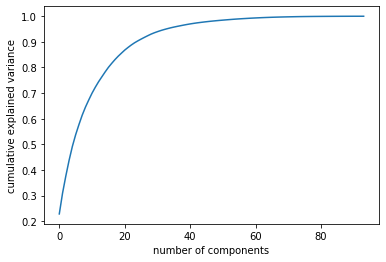

In [70]:
#plot to select number of principal components 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [71]:
#check and select elbow point

#### We can see that 95% of the variance in data can be explained using 40 principal components thereby reducing the dimension of the datasets from (94 x 500) to (94 x 40)

In [72]:
num_components = 40 # hence pick 40 PC's
pca = PCA(num_components)  
X_pca = pca.fit_transform(X_std) # fit and reduce dimension

In [73]:
X_pca

array([[-7.36980366e+00, -1.27868840e+00,  2.61393587e+00, ...,
        -7.42220995e-01, -2.51243981e-02, -6.71986283e-01],
       [-2.11997648e+00,  1.93673483e+00, -7.97419512e-01, ...,
        -6.84496920e-01, -1.15840349e+00,  4.87713025e-01],
       [ 6.32568168e-01,  1.94772239e-01, -3.18369148e+00, ...,
         2.08571357e-01,  9.67351146e-01, -6.42332706e-01],
       ...,
       [ 1.04136112e+01,  3.01945784e+01,  1.30357683e+01, ...,
        -3.91242199e-01,  2.09033698e-01, -1.01056660e+00],
       [ 1.19198381e+00,  2.06670625e+00,  1.31011453e+00, ...,
        -3.34045871e+00,  1.94803833e+00,  1.94719401e+00],
       [ 5.65641059e+00,  1.37823819e+01, -1.81251166e+00, ...,
         1.25630771e-01,  1.97972904e+00,  3.46539383e-02]])

In [74]:
X_pca.shape

(94, 40)

#### A scatter plot to show the distribution of first two principal components

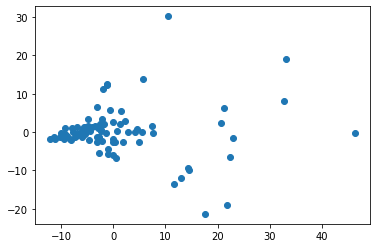

In [75]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.xlabel('first principal component')
plt.ylabel('second principal component')

plt.show()

## creating a dataframe with principal components data for further analysis

In [76]:
principal_component_columns = [f'pc_{num}' for num in range(40)]
samples = [f'sample_{num}' for num in range(94)]

In [77]:
df_X_pca = pd.DataFrame(X_pca, columns=principal_component_columns, index=samples)
df_X_pca

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39
sample_0,-7.369804,-1.278688,2.613936,0.229744,2.249910,-0.440169,0.232193,1.532076,0.121950,-0.250676,...,0.590397,0.637234,-0.755074,0.369543,1.133194,-0.469729,0.111853,-0.742221,-0.025124,-0.671986
sample_1,-2.119976,1.936735,-0.797420,0.711363,-1.119105,0.002204,-1.197658,1.578131,1.122720,-0.421234,...,-0.240685,-0.389232,1.986215,-1.783524,-2.014320,-1.141033,-0.660278,-0.684497,-1.158403,0.487713
sample_2,0.632568,0.194772,-3.183691,-1.919357,3.260973,7.699696,-5.008292,-2.585662,-1.194149,-10.545017,...,2.895741,-2.095756,-0.889829,1.296197,-2.158161,-1.818699,2.049444,0.208571,0.967351,-0.642333
sample_3,5.572086,-0.078428,8.298808,0.261203,1.066684,3.129648,-10.998196,-1.342827,-0.763920,-0.707497,...,-1.428603,0.052440,-1.253675,0.845444,0.372612,0.775555,-0.657013,0.020382,0.514366,-1.990403
sample_4,0.016480,-1.909443,-0.222108,3.605726,1.274971,0.799987,-2.211569,1.051824,-0.463479,1.876361,...,-0.687029,-0.088302,3.677030,-0.202010,-2.780995,-1.365210,4.760528,2.393754,-1.650446,-2.164497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.982151,-11.897665,-4.112073,2.270711,-4.384821,-9.513235,-5.937282,-1.873700,-6.407599,6.556440,...,3.137764,-0.637376,-2.337001,-0.715380,-0.255149,-0.799732,-0.607542,0.191781,-0.005158,0.742131
sample_90,-9.520846,-0.872806,0.373850,1.321432,0.658205,-0.692738,0.042353,1.227667,2.225624,0.726455,...,0.579400,-0.744851,0.205045,-0.888882,-0.024192,-0.191940,-0.316155,0.176915,-0.139008,0.084828
sample_91,10.413611,30.194578,13.035768,-7.831044,-3.745259,3.283891,-8.371925,-14.202833,3.063263,3.582975,...,1.857768,0.791757,0.403899,0.989834,0.508165,0.351941,0.076124,-0.391242,0.209034,-1.010567
sample_92,1.191984,2.066706,1.310115,1.034997,1.593101,-1.567227,5.865531,1.241666,-2.632559,0.212664,...,6.265078,5.187118,-0.000143,1.257661,0.088331,-1.778398,2.414596,-3.340459,1.948038,1.947194


# MODELLING

# K means on peak data

In [92]:
df

Frequency,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,Filename
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.061552,0.000000,0.060434,0.000000,0.000000,0.059094,0.000000,0.057407,0.056768,"1,4-Benzoquinone.csv"
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.197335,0.194955,0.263628,0.278836,0.000000,0.225053,0.147548,0.041053,0.068384,2-Acetylsalicylic Acid.csv
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.078529,0.089821,0.114832,0.101922,0.000000,0.128552,0.143081,0.158420,0.174568,2-Deoxy-D-Glucose.csv
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.256297,0.000000,0.390824,0.486196,0.000000,0.308901,0.321172,0.000000,0.375455,5-Acetylsalicylic Acid.csv
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.154413,0.572984,0.967579,0.519609,0.793037,0.287533,0.496496,0.324981,0.298432,9-Ethyl carbazole.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.806613,0.981674,0.575365,0.244348,0.274532,0.000000,0.376331,0.482402,0.524501,Terephthalic Acid.csv
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.079363,0.080377,0.081364,0.083262,0.082326,0.084614,0.086331,0.087944,0.089090,Tetracene.csv
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.845330,0.000000,0.865341,0.000000,0.000000,0.885430,0.000000,0.000000,0.905596,Thallium _I_ Bromide.csv
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,0.000000,-0.000069,0.000000,-0.003438,-0.005688,-0.007939,-0.010193,-0.012449,-0.014707,Thiamin Hydrochloride.csv


In [93]:
df_peak = df_peak.fillna(0)
df_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7
0,55.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1130.0,1219.0,1296.0,0.0,0.0,0.0,0.0
2,164.0,306.0,565.0,702.0,0.0,0.0,0.0
3,190.0,320.0,0.0,0.0,0.0,0.0,0.0
4,950.0,1007.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
89,836.0,922.0,975.0,0.0,0.0,0.0,0.0
90,290.0,860.0,0.0,0.0,0.0,0.0,0.0
91,128.0,707.0,0.0,0.0,0.0,0.0,0.0
92,163.0,334.0,851.0,0.0,0.0,0.0,0.0


In [94]:
frames = [df, df_peak]

result = pd.concat(frames,axis=1, sort=False)

In [95]:
result

,1,2,3,4,5,6,7,8,9,10,...,499,500,Filename,peak1,peak2,peak3,peak4,peak5,peak6,peak7
0,0.022379,0.023264,0.024693,0.024652,0.026585,0.027979,0.030146,0.030188,0.000000,0.034755,...,0.057407,0.056768,"1,4-Benzoquinone.csv",55.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.088052,0.000000,0.084851,0.000000,0.080629,0.000000,0.000000,0.077497,0.000000,0.074397,...,0.041053,0.068384,2-Acetylsalicylic Acid.csv,1130.0,1219.0,1296.0,0.0,0.0,0.0,0.0
2,0.013201,0.000000,0.011478,0.000000,0.010535,0.010426,0.000000,0.011380,0.011575,0.000000,...,0.158420,0.174568,2-Deoxy-D-Glucose.csv,164.0,306.0,565.0,702.0,0.0,0.0,0.0
3,0.261477,0.255870,0.000000,0.000000,0.250685,0.000000,0.000000,0.245921,0.000000,0.000000,...,0.000000,0.375455,5-Acetylsalicylic Acid.csv,190.0,320.0,0.0,0.0,0.0,0.0,0.0
4,0.155259,0.000000,0.000000,0.146243,0.000000,0.137560,0.000000,0.000000,0.129237,0.121274,...,0.324981,0.298432,9-Ethyl carbazole.csv,950.0,1007.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.168354,0.000000,0.160344,0.152503,0.144831,0.000000,0.137328,0.000000,0.000000,0.000000,...,0.482402,0.524501,Terephthalic Acid.csv,836.0,922.0,975.0,0.0,0.0,0.0,0.0
90,0.009779,0.011307,0.012752,0.013948,0.014715,0.014881,0.013292,0.012613,0.012230,0.013140,...,0.087944,0.089090,Tetracene.csv,290.0,860.0,0.0,0.0,0.0,0.0,0.0
91,-0.061850,-0.049871,-0.049922,0.000000,-0.037585,0.000000,-0.028052,-0.018313,-0.011685,0.000000,...,0.000000,0.905596,Thallium _I_ Bromide.csv,128.0,707.0,0.0,0.0,0.0,0.0,0.0
92,0.269335,0.261715,0.254315,0.000000,0.000000,0.243655,0.000000,0.226916,0.233436,0.220616,...,-0.012449,-0.014707,Thiamin Hydrochloride.csv,163.0,334.0,851.0,0.0,0.0,0.0,0.0


In [96]:
from sklearn.cluster import KMeans #importing K means function

In [97]:
resultant_peak=result[['peak1','peak2','peak3','peak4','peak5','peak6','peak7']] #creating a copy of database with only peak values
W = resultant_peak.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
W_std = sc.fit_transform(W) # standardizing the data
NaNs= np.isnan(W_std) #imputing NaNs in standardised data with 0's
W_std[NaNs] = 0

### To decide the K value or number of clusters:

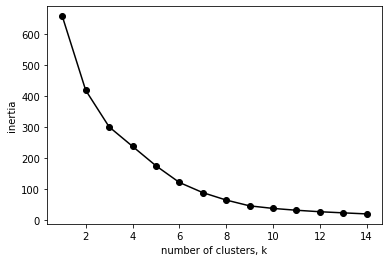

In [98]:
ks = range(1, 15) #check for 15 clusters
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters called model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(W_std)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

#### Using elbow method, K value is chosen as 6

In [99]:
kmeans_r = KMeans(n_clusters = 6)

In [100]:
kmeans_r.fit(W_std) # applying K means algorithm on standarised peak data

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [101]:
labels_full_data = kmeans_r.predict(W_std)
print(labels_full_data) #cluster assignments after K means clsutering

[0 3 2 0 5 5 0 3 3 2 0 0 2 0 3 0 5 2 0 5 0 0 0 0 0 5 5 5 0 0 0 1 0 0 0 0 0
 0 5 0 0 0 0 0 0 2 5 2 3 3 3 2 3 3 5 5 4 3 3 5 5 3 0 0 2 5 5 5 2 0 0 3 0 0
 0 0 5 2 0 3 3 0 5 0 0 0 0 3 5 3 5 5 3 2]


#### label the dataset with cluster labels obtained

In [143]:
result['labels_full_data']=labels_full_data 
result

,1,2,3,4,5,6,7,8,9,10,...,493,494,495,496,497,498,499,500,Filename,labels_full_data
0,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.00,0.03,...,0.00,0.06,0.00,0.00,0.06,0.00,0.06,0.06,"1,4-Benzoquinone.csv",0
1,0.09,0.00,0.08,0.00,0.08,0.00,0.00,0.08,0.00,0.07,...,0.19,0.26,0.28,0.00,0.23,0.15,0.04,0.07,2-Acetylsalicylic Acid.csv,3
2,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.01,0.01,0.00,...,0.09,0.11,0.10,0.00,0.13,0.14,0.16,0.17,2-Deoxy-D-Glucose.csv,2
3,0.26,0.26,0.00,0.00,0.25,0.00,0.00,0.25,0.00,0.00,...,0.00,0.39,0.49,0.00,0.31,0.32,0.00,0.38,5-Acetylsalicylic Acid.csv,0
4,0.16,0.00,0.00,0.15,0.00,0.14,0.00,0.00,0.13,0.12,...,0.57,0.97,0.52,0.79,0.29,0.50,0.32,0.30,9-Ethyl carbazole.csv,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.17,0.00,0.16,0.15,0.14,0.00,0.14,0.00,0.00,0.00,...,0.98,0.58,0.24,0.27,0.00,0.38,0.48,0.52,Terephthalic Acid.csv,3
90,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.08,0.08,0.08,0.08,0.08,0.09,0.09,0.09,Tetracene.csv,5
91,-0.06,-0.05,-0.05,0.00,-0.04,0.00,-0.03,-0.02,-0.01,0.00,...,0.00,0.87,0.00,0.00,0.89,0.00,0.00,0.91,Thallium _I_ Bromide.csv,5
92,0.27,0.26,0.25,0.00,0.00,0.24,0.00,0.23,0.23,0.22,...,-0.00,0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,Thiamin Hydrochloride.csv,3


In [126]:
df_peak['k_label'] = labels_full_data

In [127]:
df_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,k_label
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00,0
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00,3
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00,2
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00,0
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00,5
...,...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00,3
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00,5
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00,5
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00,3


# Hierarchical Clustering 

# Aggloromative heirarchial clustering on peaks

In [174]:
X_peak = df_peak

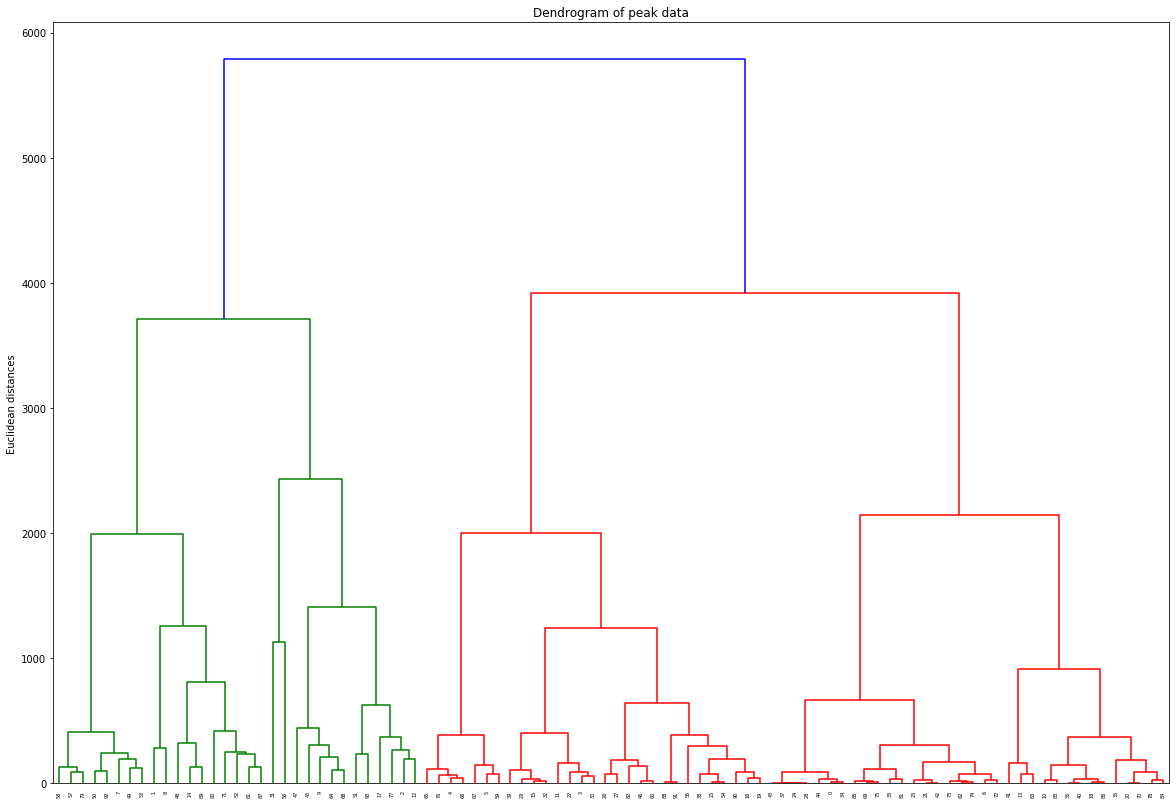

In [175]:
plt.figure(figsize=(20,14))
dendrogram_peak = sch.dendrogram(sch.linkage(X_peak, method  = "ward")) #creating a dendrogram with ward linkage method
plt.title('Dendrogram of peak data')
plt.xlabel('')
plt.ylabel('Euclidean distances')
plt.show()

#### cutting the longest line of the dendrogram to obtain 4 clusters

In [176]:
from sklearn.cluster import AgglomerativeClustering 
hc_peak = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward') #applying Agglomerative clustering onpeak data

In [177]:
y_hc_peak=hc_peak.fit_predict(X_peak)
y_hc_peak #cluster labels obtained after Aggloromerative heirarchical clustering on peaks data

array([1, 3, 0, 2, 2, 2, 1, 3, 3, 0, 1, 2, 0, 1, 3, 2, 2, 0, 1, 2, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 0, 2, 0, 3, 3, 3, 0, 3, 3, 2, 2, 0, 3, 3, 2, 2, 3, 1, 1, 0, 2,
       2, 2, 0, 1, 1, 3, 1, 1, 1, 1, 2, 0, 1, 3, 3, 1, 2, 1, 1, 1, 1, 3,
       2, 3, 2, 2, 3, 0], dtype=int64)

In [178]:
X_peak['hc_label'] = y_hc_peak #labelling the peak data with cluster labels obtained

In [179]:
X_peak # dataframe with labelled peak data

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,k_label,hc_label
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00,3,3
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00,2,0
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00,0,2
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00,5,2
...,...,...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00,3,3
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00,5,2
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00,5,2
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00,3,3


# Aggloromative heirarchical clustering on PCA data

In [180]:
X_pca

array([[-7.36980366e+00, -1.27868840e+00,  2.61393587e+00, ...,
        -7.42220995e-01, -2.51243981e-02, -6.71986283e-01],
       [-2.11997648e+00,  1.93673483e+00, -7.97419512e-01, ...,
        -6.84496920e-01, -1.15840349e+00,  4.87713025e-01],
       [ 6.32568168e-01,  1.94772239e-01, -3.18369148e+00, ...,
         2.08571357e-01,  9.67351146e-01, -6.42332706e-01],
       ...,
       [ 1.04136112e+01,  3.01945784e+01,  1.30357683e+01, ...,
        -3.91242199e-01,  2.09033698e-01, -1.01056660e+00],
       [ 1.19198381e+00,  2.06670625e+00,  1.31011453e+00, ...,
        -3.34045871e+00,  1.94803833e+00,  1.94719401e+00],
       [ 5.65641059e+00,  1.37823819e+01, -1.81251166e+00, ...,
         1.25630771e-01,  1.97972904e+00,  3.46539383e-02]])

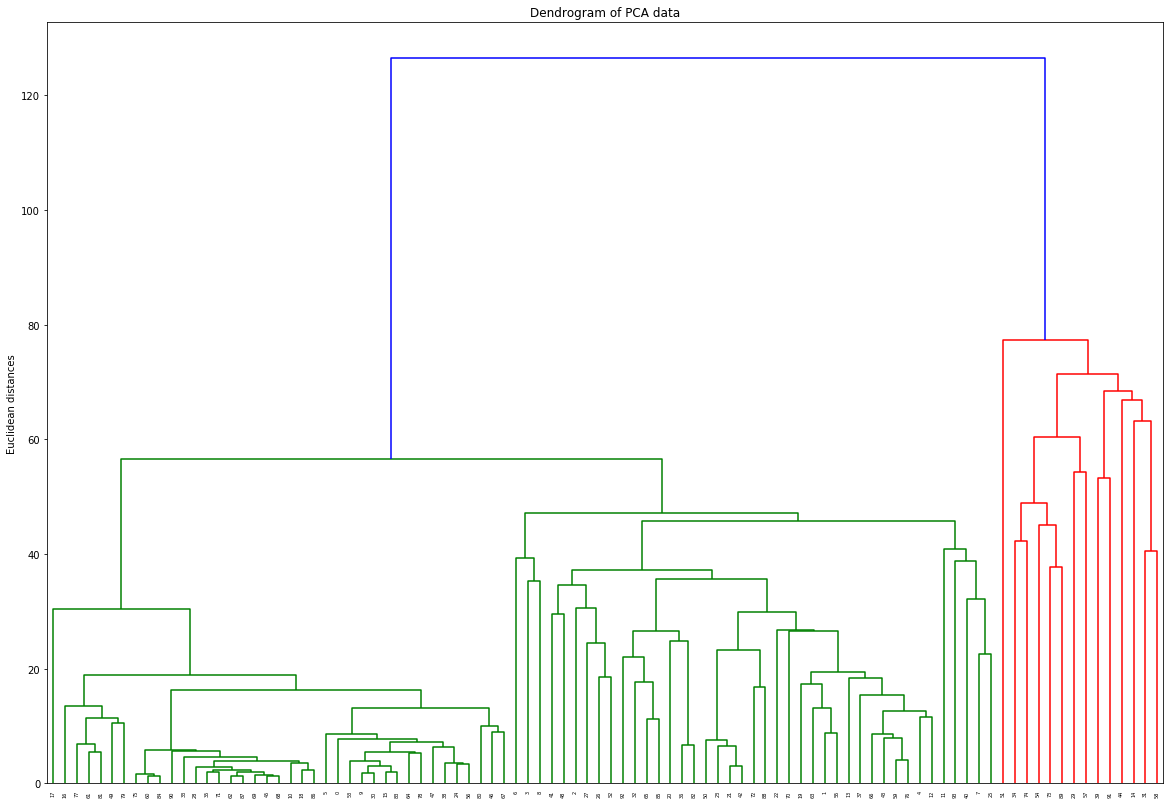

In [181]:
plt.figure(figsize=(20,14))
dendrogram_pca = sch.dendrogram(sch.linkage(X_pca, method  = "ward"))
plt.title('Dendrogram of PCA data')
plt.xlabel('')
plt.ylabel('Euclidean distances')
plt.show()

#### selecting 3 clusters after cutting tallest line of dendrogram

In [182]:
from sklearn.cluster import AgglomerativeClustering 
hc_pca = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')

In [183]:
y_hc_pca=hc_pca.fit_predict(X_pca)
y_hc_pca

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1], dtype=int64)

In [184]:
df_X_pca['hc_pca_label'] = y_hc_pca #labelling pca data with obtained labels

In [185]:
df_X_pca # labelled pca dataframe

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,k_pca_label,hc_pca_label
sample_0,-7.37,-1.28,2.61,0.23,2.25,-0.44,0.23,1.53,0.12,-0.25,...,-0.76,0.37,1.13,-0.47,0.11,-0.74,-0.03,-0.67,0,1
sample_1,-2.12,1.94,-0.80,0.71,-1.12,0.00,-1.20,1.58,1.12,-0.42,...,1.99,-1.78,-2.01,-1.14,-0.66,-0.68,-1.16,0.49,0,1
sample_2,0.63,0.19,-3.18,-1.92,3.26,7.70,-5.01,-2.59,-1.19,-10.55,...,-0.89,1.30,-2.16,-1.82,2.05,0.21,0.97,-0.64,0,1
sample_3,5.57,-0.08,8.30,0.26,1.07,3.13,-11.00,-1.34,-0.76,-0.71,...,-1.25,0.85,0.37,0.78,-0.66,0.02,0.51,-1.99,0,1
sample_4,0.02,-1.91,-0.22,3.61,1.27,0.80,-2.21,1.05,-0.46,1.88,...,3.68,-0.20,-2.78,-1.37,4.76,2.39,-1.65,-2.16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.98,-11.90,-4.11,2.27,-4.38,-9.51,-5.94,-1.87,-6.41,6.56,...,-2.34,-0.72,-0.26,-0.80,-0.61,0.19,-0.01,0.74,2,0
sample_90,-9.52,-0.87,0.37,1.32,0.66,-0.69,0.04,1.23,2.23,0.73,...,0.21,-0.89,-0.02,-0.19,-0.32,0.18,-0.14,0.08,0,1
sample_91,10.41,30.19,13.04,-7.83,-3.75,3.28,-8.37,-14.20,3.06,3.58,...,0.40,0.99,0.51,0.35,0.08,-0.39,0.21,-1.01,0,0
sample_92,1.19,2.07,1.31,1.03,1.59,-1.57,5.87,1.24,-2.63,0.21,...,-0.00,1.26,0.09,-1.78,2.41,-3.34,1.95,1.95,0,1


# K-means on PCA data

In [186]:
#Z_pca = df_pca_K.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
Z_std_pca = sc.fit_transform(X_pca) # standardizing the data
NaNs= np.isnan(Z_std_pca)
Z_std_pca[NaNs] = 0

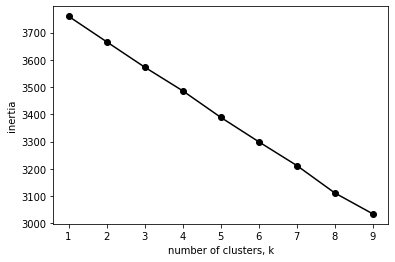

In [187]:
j = range(1, 10) #checking with 10 clusters
inertias = []
for k in j:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(Z_std_pca)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(j, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
#plt.xticks(j)
plt.show()

Elbow method cannot be used on pca data

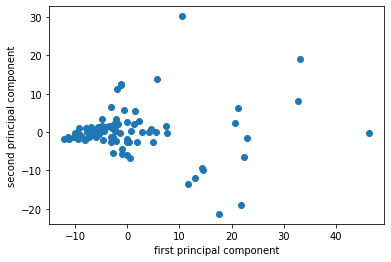

In [188]:
plt.scatter(X_pca[:,0],X_pca[:,1]) #choose 9 clusters by visualisation
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

# Choosing 9 clusters through visualisation
<img src="pca_plot.png">

In [189]:
kmeans_pca = KMeans(n_clusters = 9)

In [190]:
kmeans_pca.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [191]:
labels_pca = kmeans_pca.predict(X_pca)
print(labels_pca) #cluster labels obtained

[0 0 5 5 0 0 5 5 5 0 0 5 0 0 6 0 0 0 0 5 5 0 5 0 0 5 5 5 0 4 0 7 0 0 3 0 0
 0 0 8 5 5 0 0 1 0 0 0 5 0 0 2 5 0 3 0 0 3 7 0 0 0 0 5 0 0 0 0 0 0 5 0 5 3
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 5 3 0 5 5 5]


In [192]:
df_X_pca['k_pca_label'] = labels_pca #populating pca data with K means cluster labels

In [193]:
df_X_pca 

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,k_pca_label,hc_pca_label
sample_0,-7.37,-1.28,2.61,0.23,2.25,-0.44,0.23,1.53,0.12,-0.25,...,-0.76,0.37,1.13,-0.47,0.11,-0.74,-0.03,-0.67,0,1
sample_1,-2.12,1.94,-0.80,0.71,-1.12,0.00,-1.20,1.58,1.12,-0.42,...,1.99,-1.78,-2.01,-1.14,-0.66,-0.68,-1.16,0.49,0,1
sample_2,0.63,0.19,-3.18,-1.92,3.26,7.70,-5.01,-2.59,-1.19,-10.55,...,-0.89,1.30,-2.16,-1.82,2.05,0.21,0.97,-0.64,5,1
sample_3,5.57,-0.08,8.30,0.26,1.07,3.13,-11.00,-1.34,-0.76,-0.71,...,-1.25,0.85,0.37,0.78,-0.66,0.02,0.51,-1.99,5,1
sample_4,0.02,-1.91,-0.22,3.61,1.27,0.80,-2.21,1.05,-0.46,1.88,...,3.68,-0.20,-2.78,-1.37,4.76,2.39,-1.65,-2.16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.98,-11.90,-4.11,2.27,-4.38,-9.51,-5.94,-1.87,-6.41,6.56,...,-2.34,-0.72,-0.26,-0.80,-0.61,0.19,-0.01,0.74,3,0
sample_90,-9.52,-0.87,0.37,1.32,0.66,-0.69,0.04,1.23,2.23,0.73,...,0.21,-0.89,-0.02,-0.19,-0.32,0.18,-0.14,0.08,0,1
sample_91,10.41,30.19,13.04,-7.83,-3.75,3.28,-8.37,-14.20,3.06,3.58,...,0.40,0.99,0.51,0.35,0.08,-0.39,0.21,-1.01,5,0
sample_92,1.19,2.07,1.31,1.03,1.59,-1.57,5.87,1.24,-2.63,0.21,...,-0.00,1.26,0.09,-1.78,2.41,-3.34,1.95,1.95,5,1


# Preparing the data for further classification

### Before modelling all features must be scaled, here Standard Scalar is used

In [194]:
X_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,k_label,hc_label
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00,0,1
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00,3,3
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00,2,0
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00,0,2
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00,5,2
...,...,...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00,3,3
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00,5,2
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00,5,2
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00,3,3


# Separating features and labels

In [195]:
x_hc_peak = X_peak.drop('k_label',axis=1) #features

In [196]:
x_hc_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,hc_label
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00,1
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00,3
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00,0
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00,2
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00,2
...,...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00,3
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00,2
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00,2
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00,3


In [197]:
x_hc_peak_features = x_hc_peak.drop('hc_label',axis=1) # features

In [198]:
y_hc_peak_label = x_hc_peak['hc_label'] # label

In [199]:
x_k_peak = X_peak.drop('hc_label',axis=1)

In [200]:
x_k_peak

,peak1,peak2,peak3,peak4,peak5,peak6,peak7,k_label
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00,0
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00,3
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00,2
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00,0
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00,5
...,...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00,3
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00,5
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00,5
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00,3


In [201]:
x_k_peak_features = x_k_peak.drop('k_label',axis=1) # features
y_k_peak_label = x_k_peak['k_label'] # label
y_k_peak_label

0     0
1     3
2     2
3     0
4     5
     ..
89    3
90    5
91    5
92    3
93    2
Name: k_label, Length: 94, dtype: int32

In [202]:
df_X_pca

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,k_pca_label,hc_pca_label
sample_0,-7.37,-1.28,2.61,0.23,2.25,-0.44,0.23,1.53,0.12,-0.25,...,-0.76,0.37,1.13,-0.47,0.11,-0.74,-0.03,-0.67,0,1
sample_1,-2.12,1.94,-0.80,0.71,-1.12,0.00,-1.20,1.58,1.12,-0.42,...,1.99,-1.78,-2.01,-1.14,-0.66,-0.68,-1.16,0.49,0,1
sample_2,0.63,0.19,-3.18,-1.92,3.26,7.70,-5.01,-2.59,-1.19,-10.55,...,-0.89,1.30,-2.16,-1.82,2.05,0.21,0.97,-0.64,5,1
sample_3,5.57,-0.08,8.30,0.26,1.07,3.13,-11.00,-1.34,-0.76,-0.71,...,-1.25,0.85,0.37,0.78,-0.66,0.02,0.51,-1.99,5,1
sample_4,0.02,-1.91,-0.22,3.61,1.27,0.80,-2.21,1.05,-0.46,1.88,...,3.68,-0.20,-2.78,-1.37,4.76,2.39,-1.65,-2.16,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.98,-11.90,-4.11,2.27,-4.38,-9.51,-5.94,-1.87,-6.41,6.56,...,-2.34,-0.72,-0.26,-0.80,-0.61,0.19,-0.01,0.74,3,0
sample_90,-9.52,-0.87,0.37,1.32,0.66,-0.69,0.04,1.23,2.23,0.73,...,0.21,-0.89,-0.02,-0.19,-0.32,0.18,-0.14,0.08,0,1
sample_91,10.41,30.19,13.04,-7.83,-3.75,3.28,-8.37,-14.20,3.06,3.58,...,0.40,0.99,0.51,0.35,0.08,-0.39,0.21,-1.01,5,0
sample_92,1.19,2.07,1.31,1.03,1.59,-1.57,5.87,1.24,-2.63,0.21,...,-0.00,1.26,0.09,-1.78,2.41,-3.34,1.95,1.95,5,1


In [203]:
x_k_pca = df_X_pca.drop('hc_pca_label',axis=1) #training features
x_k_pca

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,k_pca_label
sample_0,-7.37,-1.28,2.61,0.23,2.25,-0.44,0.23,1.53,0.12,-0.25,...,0.64,-0.76,0.37,1.13,-0.47,0.11,-0.74,-0.03,-0.67,0
sample_1,-2.12,1.94,-0.80,0.71,-1.12,0.00,-1.20,1.58,1.12,-0.42,...,-0.39,1.99,-1.78,-2.01,-1.14,-0.66,-0.68,-1.16,0.49,0
sample_2,0.63,0.19,-3.18,-1.92,3.26,7.70,-5.01,-2.59,-1.19,-10.55,...,-2.10,-0.89,1.30,-2.16,-1.82,2.05,0.21,0.97,-0.64,5
sample_3,5.57,-0.08,8.30,0.26,1.07,3.13,-11.00,-1.34,-0.76,-0.71,...,0.05,-1.25,0.85,0.37,0.78,-0.66,0.02,0.51,-1.99,5
sample_4,0.02,-1.91,-0.22,3.61,1.27,0.80,-2.21,1.05,-0.46,1.88,...,-0.09,3.68,-0.20,-2.78,-1.37,4.76,2.39,-1.65,-2.16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.98,-11.90,-4.11,2.27,-4.38,-9.51,-5.94,-1.87,-6.41,6.56,...,-0.64,-2.34,-0.72,-0.26,-0.80,-0.61,0.19,-0.01,0.74,3
sample_90,-9.52,-0.87,0.37,1.32,0.66,-0.69,0.04,1.23,2.23,0.73,...,-0.74,0.21,-0.89,-0.02,-0.19,-0.32,0.18,-0.14,0.08,0
sample_91,10.41,30.19,13.04,-7.83,-3.75,3.28,-8.37,-14.20,3.06,3.58,...,0.79,0.40,0.99,0.51,0.35,0.08,-0.39,0.21,-1.01,5
sample_92,1.19,2.07,1.31,1.03,1.59,-1.57,5.87,1.24,-2.63,0.21,...,5.19,-0.00,1.26,0.09,-1.78,2.41,-3.34,1.95,1.95,5


In [204]:
x_k_pca_features = x_k_pca.drop('k_pca_label',axis=1) # features

In [205]:
y_k_pca_label = x_k_pca['k_pca_label'] #label

In [206]:
x_hc_pca = df_X_pca.drop('k_pca_label',axis=1) # features
x_hc_pca

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,pc_39,hc_pca_label
sample_0,-7.37,-1.28,2.61,0.23,2.25,-0.44,0.23,1.53,0.12,-0.25,...,0.64,-0.76,0.37,1.13,-0.47,0.11,-0.74,-0.03,-0.67,1
sample_1,-2.12,1.94,-0.80,0.71,-1.12,0.00,-1.20,1.58,1.12,-0.42,...,-0.39,1.99,-1.78,-2.01,-1.14,-0.66,-0.68,-1.16,0.49,1
sample_2,0.63,0.19,-3.18,-1.92,3.26,7.70,-5.01,-2.59,-1.19,-10.55,...,-2.10,-0.89,1.30,-2.16,-1.82,2.05,0.21,0.97,-0.64,1
sample_3,5.57,-0.08,8.30,0.26,1.07,3.13,-11.00,-1.34,-0.76,-0.71,...,0.05,-1.25,0.85,0.37,0.78,-0.66,0.02,0.51,-1.99,1
sample_4,0.02,-1.91,-0.22,3.61,1.27,0.80,-2.21,1.05,-0.46,1.88,...,-0.09,3.68,-0.20,-2.78,-1.37,4.76,2.39,-1.65,-2.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_89,12.98,-11.90,-4.11,2.27,-4.38,-9.51,-5.94,-1.87,-6.41,6.56,...,-0.64,-2.34,-0.72,-0.26,-0.80,-0.61,0.19,-0.01,0.74,0
sample_90,-9.52,-0.87,0.37,1.32,0.66,-0.69,0.04,1.23,2.23,0.73,...,-0.74,0.21,-0.89,-0.02,-0.19,-0.32,0.18,-0.14,0.08,1
sample_91,10.41,30.19,13.04,-7.83,-3.75,3.28,-8.37,-14.20,3.06,3.58,...,0.79,0.40,0.99,0.51,0.35,0.08,-0.39,0.21,-1.01,0
sample_92,1.19,2.07,1.31,1.03,1.59,-1.57,5.87,1.24,-2.63,0.21,...,5.19,-0.00,1.26,0.09,-1.78,2.41,-3.34,1.95,1.95,1


In [207]:
x_hc_pca_features = x_hc_pca.drop('hc_pca_label',axis=1)

In [208]:
y_hc_pca_label = x_hc_pca['hc_pca_label'] 

In [209]:
x_hc_peak_features

,peak1,peak2,peak3,peak4,peak5,peak6,peak7
0,55.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1130.00,1219.00,1296.00,0.00,0.00,0.00,0.00
2,164.00,306.00,565.00,702.00,0.00,0.00,0.00
3,190.00,320.00,0.00,0.00,0.00,0.00,0.00
4,950.00,1007.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...
89,836.00,922.00,975.00,0.00,0.00,0.00,0.00
90,290.00,860.00,0.00,0.00,0.00,0.00,0.00
91,128.00,707.00,0.00,0.00,0.00,0.00,0.00
92,163.00,334.00,851.00,0.00,0.00,0.00,0.00


In [210]:
# Scaling all the features using StandardScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
x_hc_peak_features = pd.DataFrame(std_scaler.fit_transform(x_hc_peak_features), columns=list(x_hc_peak_features.columns))
x_k_peak_features = pd.DataFrame(std_scaler.fit_transform(x_k_peak_features), columns=list(x_k_peak_features.columns))

In [211]:
x_hc_pca_features = pd.DataFrame(std_scaler.fit_transform(x_hc_pca_features), columns=list(x_hc_pca_features.columns))
x_k_pca_features = pd.DataFrame(std_scaler.fit_transform(x_k_pca_features), columns=list(x_k_pca_features.columns))

In [212]:
#splitting data into train and test set in the ratio 8:2
from sklearn.model_selection import train_test_split
x_hc_peak_train, x_hc_peak_test, y_hc_peak_train, y_hc_peak_test = train_test_split(x_hc_peak_features, y_hc_peak_label, test_size=0.2, random_state=123)
x_hc_pca_train, x_hc_pca_test, y_hc_pca_train, y_hc_pca_test = train_test_split(x_hc_pca_features, y_hc_pca_label, test_size=0.2, random_state=123)
x_k_peak_train, x_k_peak_test, y_k_peak_train, y_k_peak_test = train_test_split(x_k_peak_features, y_k_peak_label, test_size=0.2, random_state=123)
x_k_pca_train, x_k_pca_test, y_k_pca_train, y_k_pca_test = train_test_split(x_k_pca_features, y_k_pca_label, test_size=0.2, random_state=123)

## Classifier 1: Logistic Regression

#### An attempt to find out which clustering algorithm is suitable for labeling the unlablled dataset and classfying the new samples is carried out by applyling logistic regression on 4 sets of models and comparing their performances to find out the best performing one.

The 4 sets of models are: 

Model 1:logistic regression model for peak data from K-means clustering

Model 2:logistic regression model for pca data from K-means clustering

Model 3:logistic regression model for peak data from heirarchical clustering

Model 4:logistic regression model for pca data from Hierarchical clustering


# Model 1: logistic regression model for peak data from K-means clustering

In [278]:
#create a logistic regression model for peak data from K-means clustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report



logr_model=LogisticRegression(solver='lbfgs')
#train the model using train set
logr_model.fit(x_k_peak_train,y_k_peak_train)
y_train_pred_logr=logr_model.predict(x_k_peak_train)
#make predictions using the test set
y_test_pred_logr=logr_model.predict(x_k_peak_test)

misclassified_samples = (y_k_pca_test !=  y_test_pred_logr).sum()
print(misclassified_samples)

#printing the results
print(classification_report(y_k_peak_test, y_test_pred_logr))

11
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.00      0.00      0.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1

    accuracy                           0.95        19
   macro avg       0.73      0.80      0.76        19
weighted avg       0.91      0.95      0.93        19



Text(0, 0.5, 'Actual Value')

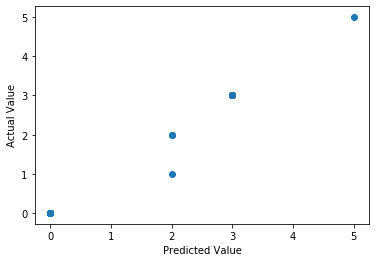

In [279]:
plt.scatter(y_test_pred_logr, y_k_peak_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Model 2: logistic regression model for pca data from K-means clustering

In [235]:
#create a logistic regression model for pca data from K-means clustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logr_model=LogisticRegression(solver='lbfgs')
#train the model using train set
logr_model.fit(x_k_pca_train,y_k_pca_train)
y_train_pred_logr=logr_model.predict(x_k_pca_train)
#make predictions using the test set
y_test_pred_logr=logr_model.predict(x_k_pca_test)

misclassified_samples = (y_k_pca_test !=  y_test_pred_logr).sum()
print(misclassified_samples)

#printing the results
print(classification_report(y_k_pca_test, y_test_pred_logr))

6
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        12
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         1

    accuracy                           0.68        19
   macro avg       0.28      0.22      0.22        19
weighted avg       0.58      0.68      0.58        19



Text(0, 0.5, 'Actual Value')

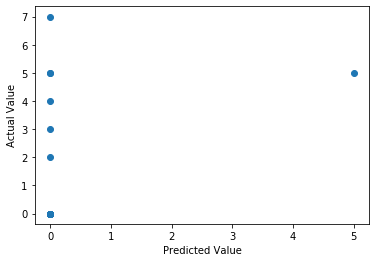

In [230]:
plt.scatter(y_test_pred_logr, y_k_pca_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Model 3: logistic regression model for peak data from heirarchical clustering

In [344]:
#create a logistic regression model for peak data from heirarchical clustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logr_model=LogisticRegression(solver='lbfgs') #mutinominal logistic regression
#train the model using train set
logr_model.fit(x_hc_peak_train,y_hc_peak_train)
y_train_pred_logr=logr_model.predict(x_hc_peak_train)
#make predictions using the test set
y_test_pred_logr=logr_model.predict(x_hc_peak_test)

misclassified_samples = (y_hc_peak_test !=  y_test_pred_logr).sum()
print(misclassified_samples)
#printing the results
print(classification_report(y_hc_peak_test, y_test_pred_logr))

0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



Text(0, 0.5, 'Actual Value')

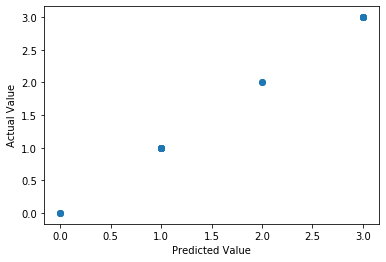

In [345]:
plt.scatter(y_test_pred_logr, y_hc_peak_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

#### we can see above that it suffers from overfitting

# Model 4: logistic regression model for pca data from Hierarchical clustering

In [234]:
#create a logistic regression model for pca data from Hierarchical clustering
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logr_model=LogisticRegression(solver='lbfgs')
#train the model using train set
logr_model.fit(x_hc_pca_train,y_hc_pca_train)
y_train_pred_logr=logr_model.predict(x_hc_pca_train)
#make predictions using the test set
y_test_pred_logr=logr_model.predict(x_hc_pca_test)

misclassified_samples = (y_hc_pca_test !=  y_test_pred_logr).sum()
print(misclassified_samples)


#printing the results
print(classification_report(y_hc_pca_test, y_test_pred_logr))

4
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.79      1.00      0.88        15
           2       0.00      0.00      0.00         1

    accuracy                           0.79        19
   macro avg       0.26      0.33      0.29        19
weighted avg       0.62      0.79      0.70        19



Text(0, 0.5, 'Actual Value')

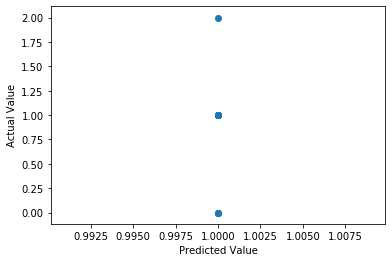

In [232]:
plt.scatter(y_test_pred_logr, y_hc_pca_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Base model/ Classifer 1 comparison

In [339]:
# storing weighted avg F1 scores from the report into variables for plotting
m1 = 0.93 #LR model(peak data from K-means)
m2 = 0.58 #LR model(PCA data from K-means)
m3 = 1 #LR model(peak data from HC)
m4 = 0.7 #LR model(pca data from HC)
d = 0.95 #decison tree classifier
xg = 0.93 #xgboost classifier

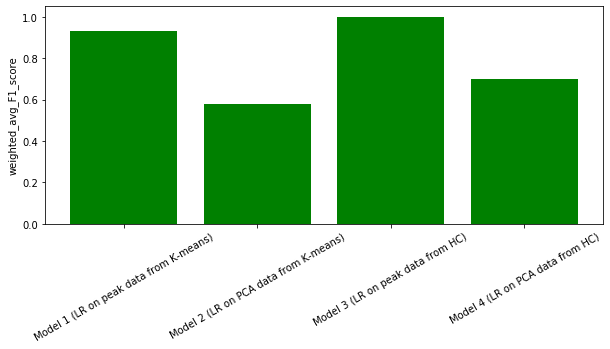

In [340]:
#plotting weighted avg F1 score of all models
plt.figure(figsize=(10, 4))
models = ['Model 1 (LR on peak data from K-means)', 'Model 2 (LR on PCA data from K-means)', 'Model 3 (LR on peak data from HC)', 'Model 4 (LR on PCA data from HC)']#labels
other_classfiers= ['Decision Tree', 'XGBoost']
weighted_avg_F1_score_m = [m1,m2,m3,m4]#values
index = np.arange(len(models))
plt.bar(index, weighted_avg_F1_score_m, color="g")
#plt.xlabel('Models', fontsize=10)
plt.ylabel('weighted_avg_F1_score', fontsize=10)
plt.xticks(index, models, fontsize=10, rotation=30)
plt.show()

### Model 1 performs better in terms of accuracy and weighted average F1 score hence the cluster labels assigned from K-means using peaks data is chosen for further analysis

# Classifier 2: Decision Tree Classifier

In [263]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
dt_model = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_model = dt_model.fit(x_k_peak_train,y_k_peak_train)



#Predict the response for test dataset
y_test_pred_dt = dt_model.predict(x_k_peak_test)

In [265]:
misclassified_samples = (y_k_peak_test !=  y_test_pred_dt).sum()
print(misclassified_samples)


#printing the results
print(classification_report(y_k_peak_test, y_test_pred_dt))

1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         6
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         1

    accuracy                           0.95        19
   macro avg       0.67      0.67      0.67        19
weighted avg       0.95      0.95      0.95        19



Text(0, 0.5, 'Actual Value')

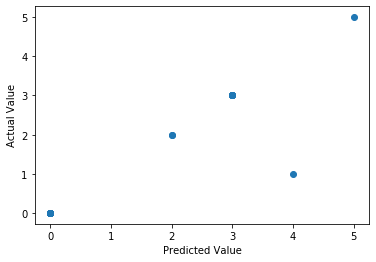

In [275]:
plt.scatter(y_test_pred_dt, y_k_peak_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Classifier 3: XGB Classifier

In [271]:
import xgboost as xgb

In [277]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=123)
xgb_model.fit(x_k_peak_train,y_k_peak_train)

y_test_pred_xgb = xgb_model.predict(x_k_peak_test)

misclassified_samples = (y_k_peak_test !=  y_test_pred_xgb).sum()
print(misclassified_samples)


print(classification_report(y_k_peak_test, y_test_pred_xgb))

1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.00      0.00      0.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         1

    accuracy                           0.95        19
   macro avg       0.73      0.80      0.76        19
weighted avg       0.91      0.95      0.93        19



Text(0, 0.5, 'Actual Value')

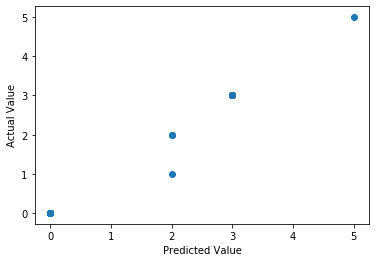

In [276]:
plt.scatter(y_test_pred_xgb, y_k_peak_test, marker='o')
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

# Comparison of performance Classifier 2 and 3

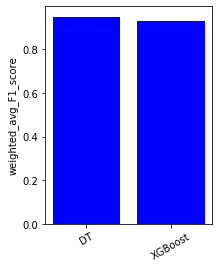

In [334]:
#plotting weighted average F1 of other classifiers
plt.figure(figsize=(3, 4))
models = ['DT', 'XGBoost']#labels
other_classfiers= ['Decision Tree', 'XGBoost']
weighted_avg_F1_score_m = [d,xg]#values
index = np.arange(len(models))
plt.bar(index, weighted_avg_F1_score_m, color="b")
#plt.xlabel('Models', fontsize=10)
plt.ylabel('weighted_avg_F1_score', fontsize=10)
plt.xticks(index, models, fontsize=10, rotation=30)
plt.show()

In [347]:
# There not much improvement of classifiers 2 and 3 from the base model